## PCA Shape Model of Detecting Spinal Abnormalities

The goal is to implement the construction of a PCA shape model that can be used to detect abnormal spinal shapes. The PCA model will be trained on a set of 200 subjects with normal spines. For testing, we will use a set of 242 patients with spinal pathologies. The PCA model will allow us to automatically detect the most extreme cases of spinal deformities.

In some parts, there are multiple options, such as different methods for shape alignment. Try out to run the whole chain of processing with different options and compare the results.

The first code section is defining some helper functions and provides a full implementation of the two Umeyama methods for rigid-body and similarity transformations.

In [2]:
import numpy as np

import matplotlib.pyplot as plt
import matplotlib.cm as cm
from mpl_toolkits.mplot3d import Axes3D
%matplotlib inline

def axisEqual3D(ax):
    extents = np.array([getattr(ax, 'get_{}lim'.format(dim))() for dim in 'xyz'])
    sz = extents[:,1] - extents[:,0]
    centers = np.mean(extents, axis=1)
    maxsize = max(abs(sz))
    r = maxsize/2
    for ctr, dim in zip(centers, 'xyz'):
        getattr(ax, 'set_{}lim'.format(dim))(ctr - r/3, ctr + r/3)

def plotmy3Ddata(input_data,title='',view=[35,-50]):
    dim,num_samples = input_data.shape
    num_centroids = dim/3;
    x_ind = range(num_centroids)
    y_ind = range(num_centroids,num_centroids*2)
    z_ind = range(num_centroids*2,num_centroids*3)
    fig = plt.figure(figsize=(16, 10));
    ax = fig.add_subplot(111, projection='3d');
    colors = iter(cm.rainbow(np.linspace(0, 1, num_samples)))        
    for col in range(num_samples):
        c_color = next(colors)
        ax.scatter(input_data[x_ind,col], input_data[y_ind,col], input_data[z_ind,col], color=c_color, s=16, marker='.')
        ax.plot(input_data[x_ind,col], input_data[y_ind,col], input_data[z_ind,col], color=c_color)
    ax.set_title(title,fontsize=20,x=0.65,y=0.95)
    axisEqual3D(ax)
    ax.view_init(view[0],view[1])
    plt.show()
    
# Implementation of the Umeyama method for computing rigid-body transformations
def umeyama_rigid(X, Y):
    
    # Get dimension and number of points
    m, n = X.shape

    # Demean the point sets X and Y
    X_mean = X.mean(1) #MODEL ANSWER
    Y_mean = Y.mean(1) #MODEL ANSWER
    X_demean =  X - np.tile(X_mean, (n, 1)).T #MODEL ANSWER
    Y_demean =  Y - np.tile(Y_mean, (n, 1)).T #MODEL ANSWER

    # Computing matrix XY' using demeaned point sets
    XY = np.dot(X_demean, Y_demean.T) #MODEL ANSWER

    # Singular value decomposition
    U,D,V = np.linalg.svd(XY,full_matrices=True,compute_uv=True)
    V=V.T.copy()
    
    # Determine rotation
    R = np.dot( V, U.T) #MODEL ANSWER

    # Determine translation
    t = Y_mean - np.dot(R, X_mean) #MODEL ANSWER
    
    return R,t

# Implementation of the Umeyama method for computing similarity transformations
def umeyama_similarity(X, Y):
    
    # Get dimension and number of points
    m, n = X.shape

    # Demean the point sets X and Y
    X_mean = X.mean(1) #MODEL ANSWER
    Y_mean = Y.mean(1) #MODEL ANSWER
    X_demean =  X - np.tile(X_mean, (n, 1)).T #MODEL ANSWER
    Y_demean =  Y - np.tile(Y_mean, (n, 1)).T #MODEL ANSWER

    # Computing matrix XY' using demeaned and NORMALISED point sets (divide by the number of points n)
    # See Equation (38) in the paper
    XY = np.dot(X_demean, Y_demean.T) / n  #MODEL ANSWER

    # Determine variances of points X and Y, see Equation (36),(37) in the paper
    X_var = np.mean(np.sum(X_demean*X_demean, 0))
    Y_var = np.mean(np.sum(Y_demean*Y_demean, 0))

    # Singular value decomposition
    U,D,V = np.linalg.svd(XY,full_matrices=True,compute_uv=True)
    V=V.T.copy()
    
    # Determine rotation
    R = np.dot( V, U.T) #MODEL ANSWER
    
    # Determine the scaling, see Equation (42) in the paper (assume S to be the identity matrix, so ignore)
    c = np.trace(np.diag(D)) / X_var #MODEL ANSWER

    # Determine translation, see Equation (41) in the paper
    t = Y_mean - c * np.dot(R, X_mean) #MODEL ANSWER

    return R,c,t

## Loading the training data

The cell below is loading the training data and visualises the 200 spines.

num of dimension: 78
num of training examples: 200


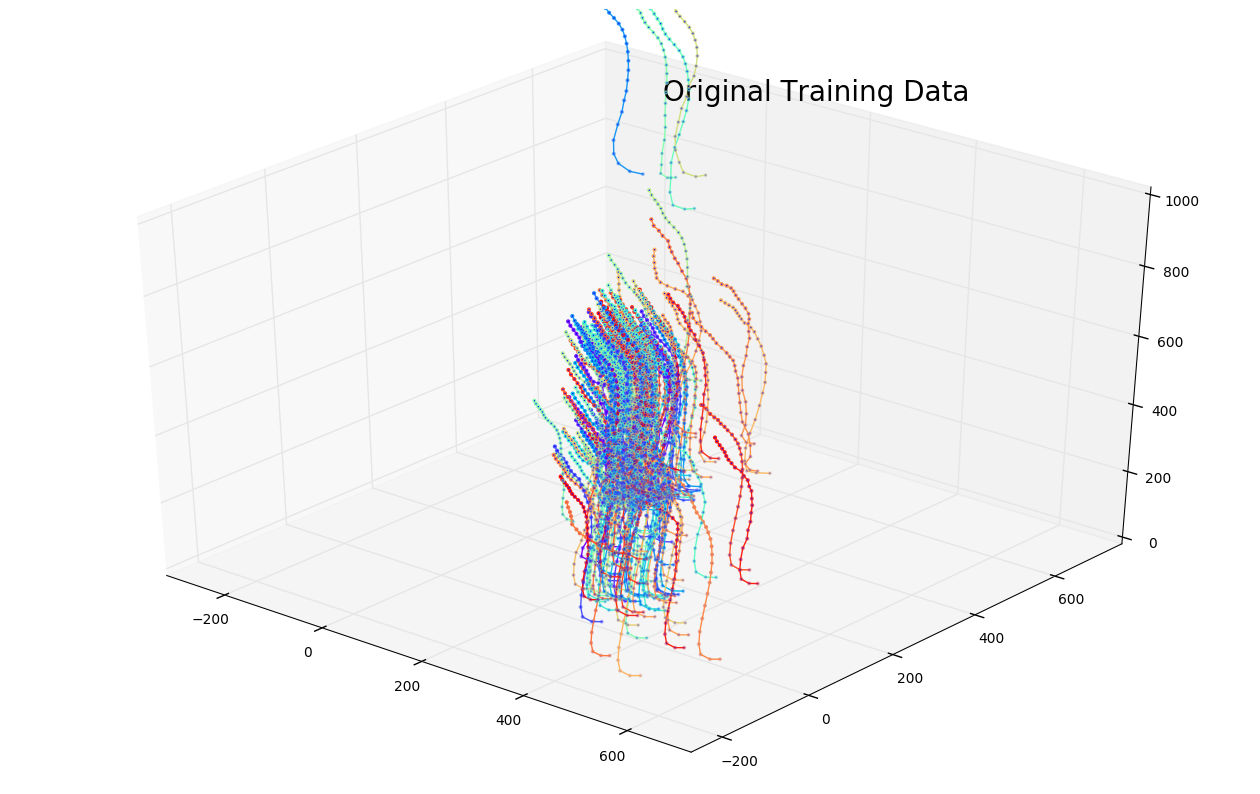

In [3]:
train_data = np.genfromtxt('../data/spine_training.txt')
dimension,num_examples_train = train_data.shape

num_centroids = dimension/3;
x_ind = range(num_centroids)
y_ind = range(num_centroids,num_centroids*2)
z_ind = range(num_centroids*2,num_centroids*3)

print 'num of dimension: %d' % dimension
print 'num of training examples: %d' % num_examples_train

plotmy3Ddata(train_data,title='Original Training Data')

## Pre-processing

In order to build a shape model using PCA, we first need to align the shapes in some sensible way. Otherwise, we would capture variation between shapes that is mainly coming from the fact the original images weren't registered. The above plot of the original input data illustrates this issue.

There are several ways of establishing alignment between those shapes. The alignment will have an impact on the principal components (for instance whether scale is considered), and depending on the application one might want to use different alignment methods. Remember, that we know the correspondences between the shape, so we could for instance use different variants of the Umeyama method.

#### TASK I: Implement three different methods for shape alignement. 1) Center-of-mass alignment (here, the center-of-mass corresponds to the geometric mean), 2) Rigid-body alignment using Umeyama, 3) Similarity alignment using Umeyama.

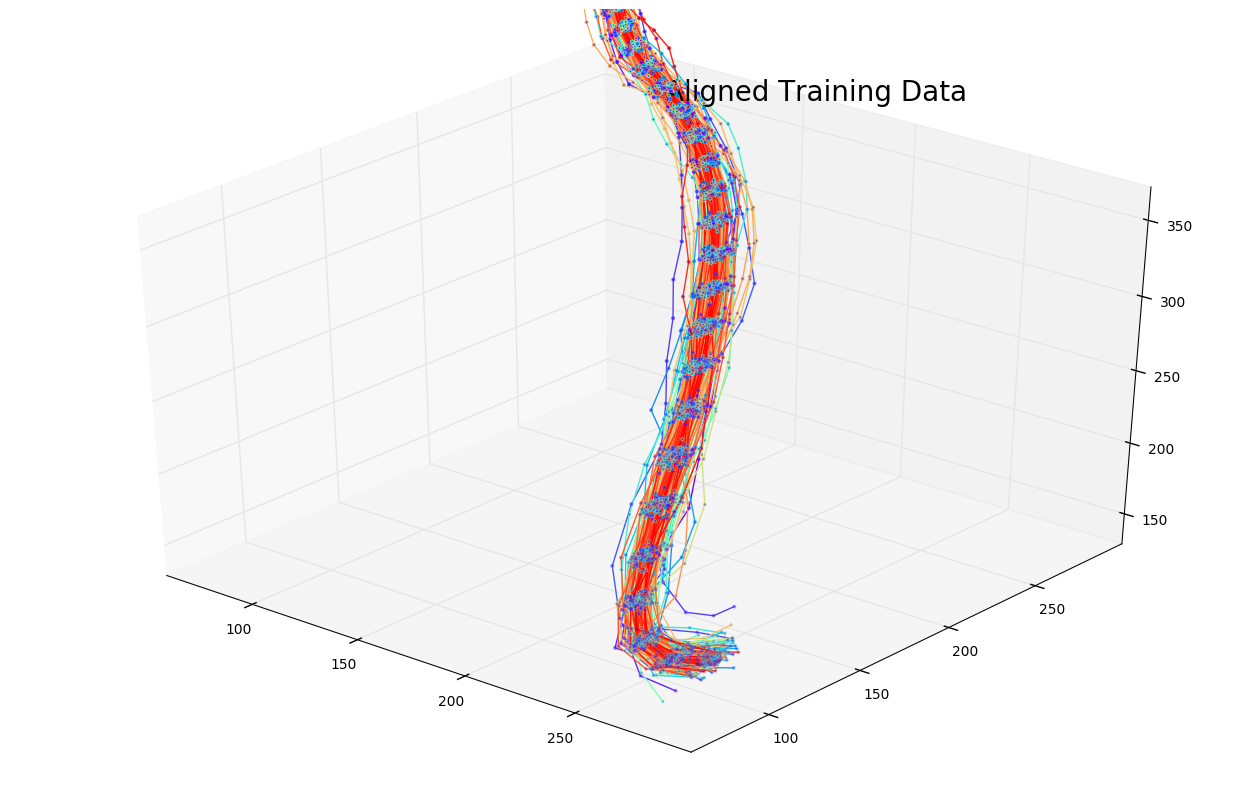

In [11]:
# pre-processing: align shapes - three variants

# 1: center-of-mass alignment
# 2: rigid-body alignment
# 3: similarity alignment
align = 3;
aligned_data = np.zeros(train_data.shape); 

if align == 1:
    cx = train_data[x_ind,:];
    cy = train_data[y_ind,:];
    cz = train_data[z_ind,:];
        
    aligned_data[x_ind,:] = cx - np.tile(np.mean(cx,axis=0),(num_centroids,1));
    aligned_data[y_ind,:] = cy - np.tile(np.mean(cy,axis=0),(num_centroids,1));
    aligned_data[z_ind,:] = cz - np.tile(np.mean(cz,axis=0),(num_centroids,1));   
    
elif align == 2:
    ref_shape = train_data[:,0].reshape((3, num_centroids))
    for ii in range(1,num_examples_train):
        mov_shape = train_data[:,ii].reshape((3, num_centroids))
        R, t = umeyama_rigid(mov_shape,ref_shape)
        mov_shape = np.dot(R,mov_shape) + np.tile(t, (num_centroids, 1)).transpose()
        aligned_data[:,ii] = mov_shape.reshape((3*num_centroids,1)).flatten()
    aligned_data[:,0] = train_data[:,0];
    
elif align == 3:
    ref_shape = train_data[:,0].reshape((3, num_centroids))
    for ii in range(1,num_examples_train):
        mov_shape = train_data[:,ii].reshape((3, num_centroids))
        R, c, t = umeyama_similarity(mov_shape,ref_shape)
        mov_shape = c * np.dot(R,mov_shape) + np.tile(t, (num_centroids, 1)).transpose()
        aligned_data[:,ii] = mov_shape.reshape((3*num_centroids,1)).flatten()
    aligned_data[:,0] = train_data[:,0];

plotmy3Ddata(aligned_data,title='Aligned Training Data')

## Principal Component Analysis

Once the shapes are aligned, we can run PCA to obtain the principal modes and the corresponding variances. The PCA is explained in the lecture slides. Remember, the columns of the U matrix are the principal modes, and the D matrix contains the variance per mode on its diagonal.

The code below has some missing lines which you need to complete. Once, the PCA is working the rest of the code estimates the number of modes that you need in order to retain either 95% or 99% of the variance. This is for your information only. Try out how this changes with different shape alignment methods.

#### TASK II: Fill in the missing lines of code in order to implement the second variant of PCA as described in the lecture notes.

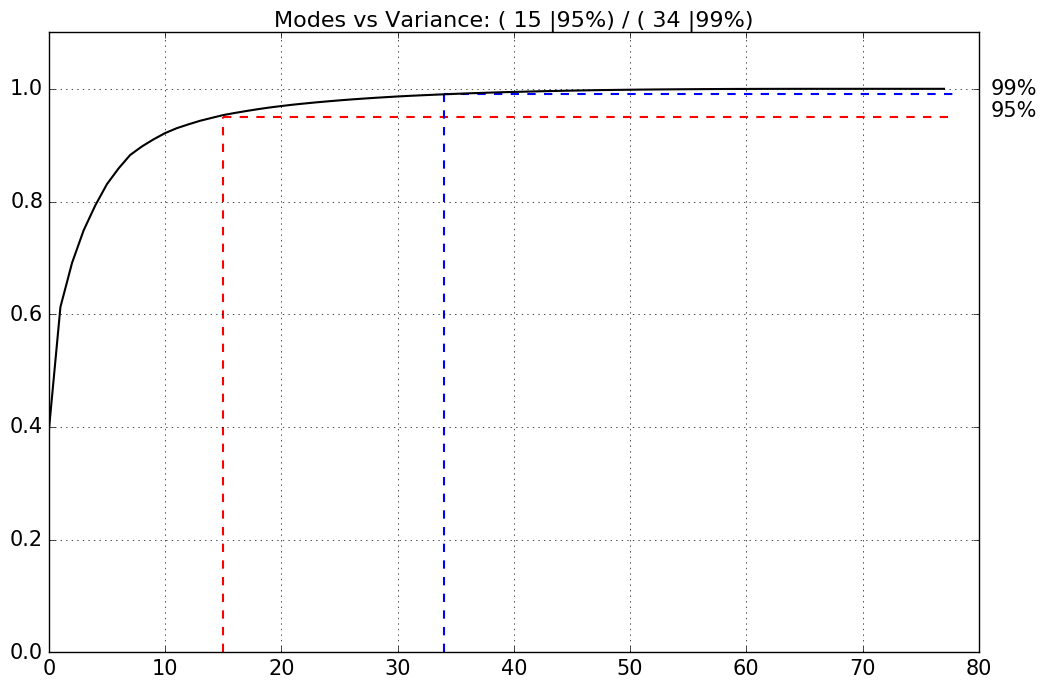

In [12]:
# Perform Shape PCA

# compute the mean over all samples
aligned_data_mean = np.mean(aligned_data,axis=1);

# demean data
aligned_data_m = aligned_data - np.transpose(np.tile(aligned_data_mean,(num_examples_train,1)));

# get eigenvectors and eigenvalues via SVD
U, D, V = np.linalg.svd( aligned_data_m / np.sqrt(num_examples_train-1), full_matrices=True);
D = np.multiply(D, D)

# get the retained variance with increasing number of modes
retained_variance = np.cumsum(D) / np.sum(D);

# get number of modes to retain 95% of variance (from 0 to num_modes_95)
num_modes_95 = next(idx for idx,v in enumerate(retained_variance) if v > 0.95)

# get number of modes to retain 99% of variance (from 0 to num_modes_99)
num_modes_99 = next(idx for idx,v in enumerate(retained_variance) if v > 0.99)

fig = plt.figure(figsize=(12, 8));
ax = fig.add_subplot(111);
ax.plot([num_modes_95,num_centroids*3],[0.95,0.95],color='r',linestyle='--',linewidth=1.5); ax.text(dimension+3, 0.95,'95%', fontsize=15)
ax.plot([num_modes_99,num_centroids*3],[0.99,0.99],color='b',linestyle='--',linewidth=1.5); ax.text(dimension+3, 0.99,'99%', fontsize=15)
ax.plot([num_modes_95,num_modes_95],[0,0.95],color='r',linestyle='--',linewidth=1.5)
ax.plot([num_modes_99,num_modes_99],[0,0.99],color='b',linestyle='--',linewidth=1.5)
ax.plot(retained_variance,color='k',linewidth=1.5)
ax.grid(True)
ax.tick_params(axis='both', which='major', labelsize=15)
x1,x2,y1,y2 = plt.axis()
plt.axis((x1,x2,0,1.1))
ax.set_title("Modes vs Variance: ( {0} |95%) / ( {1} |99%)".format(num_modes_95,num_modes_99),fontsize=16)
plt.show()

## Modes of Variation

A very useful technique when building a PCA shape model is the visualisation of the main modes. In the next section, we are going to visualise the variation from the mean shape for all modes that are needed in order to retain 95% of the variance. To do this, you need to take the mean shape and add and subtract a principal mode scaled with three times the standard deviation. Remember that the standard deviation is the square root of the variance.

#### TASK III: Implement the construction of shapes that correspond to the positive and negative variation of the mean shape. To this end, take the mean shape and add and subtract a mode scaled by three times the standard deviation.

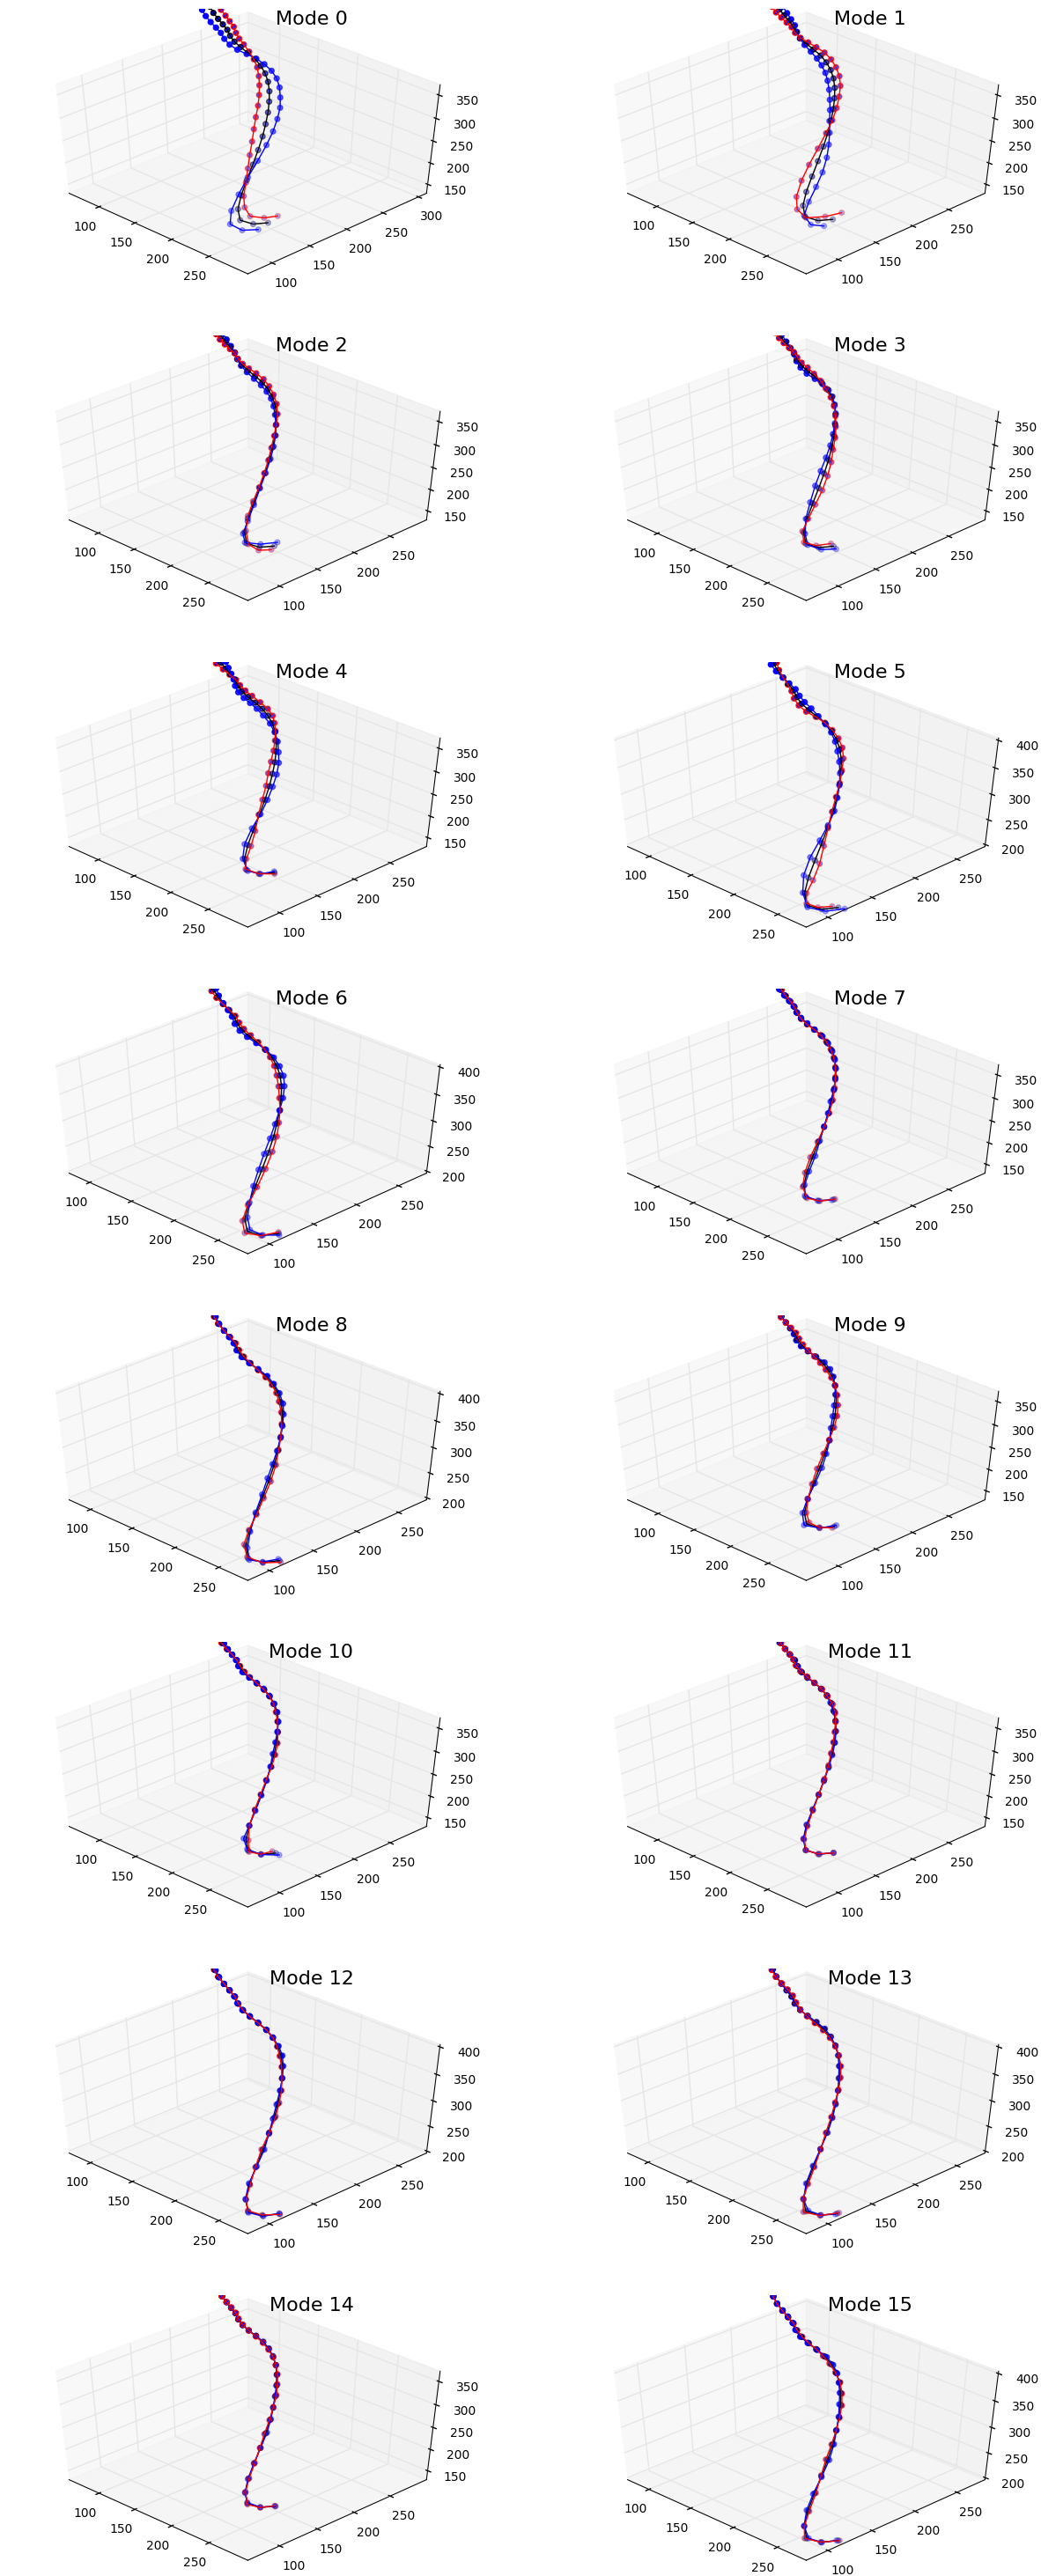

In [13]:
#plot variation of mean shape for the modes of 95% variance

fig = plt.figure(figsize=(15, 2.5*num_modes_95));
for ii in range(num_modes_95+1):

    # add and subtract 3 times the standard deviation (which contains 99.7% of the data)
    sp = aligned_data_mean + U[:,ii] * np.sqrt(D[ii]) * 3
    sn = aligned_data_mean - U[:,ii] * np.sqrt(D[ii]) * 3
    
    ax = fig.add_subplot(np.ceil((num_modes_95+1)/float(2)),2,ii+1, projection='3d');
    ax.scatter(aligned_data_mean[x_ind], aligned_data_mean[y_ind], aligned_data_mean[z_ind], s=70, marker='.', color='k')
    ax.scatter(sp[x_ind], sp[y_ind], sp[z_ind], s=70, marker='.', color='b')
    ax.scatter(sn[x_ind], sn[y_ind], sn[z_ind], s=70, marker='.', color='r')
    ax.plot(aligned_data_mean[x_ind], aligned_data_mean[y_ind], aligned_data_mean[z_ind], color='k')
    ax.plot(sp[x_ind], sp[y_ind], sp[z_ind], color='b')
    ax.plot(sn[x_ind], sn[y_ind], sn[z_ind], color='r')
    ax.set_title('Mode {0}'.format(ii),fontsize=16,x=0.65)
    ax.view_init(45,-45)
    #ax.view_init(0,0)
    #ax.view_init(0,90)
    axisEqual3D(ax)

plt.show()

## Sampling from PCA Model

The following section is for illustration purposes only. Once the PCA model is constructed, we can generate random samples from the model. The model is also called a 'generative' model, as it allows the sampling of examples that follow the underlying distribution.

You can play with the scaling factor which allows you to influence the amount of variation. If you set the scaling such that it generates shapes with more than three times the standard deviation, you might see anatomically implausible shapes.

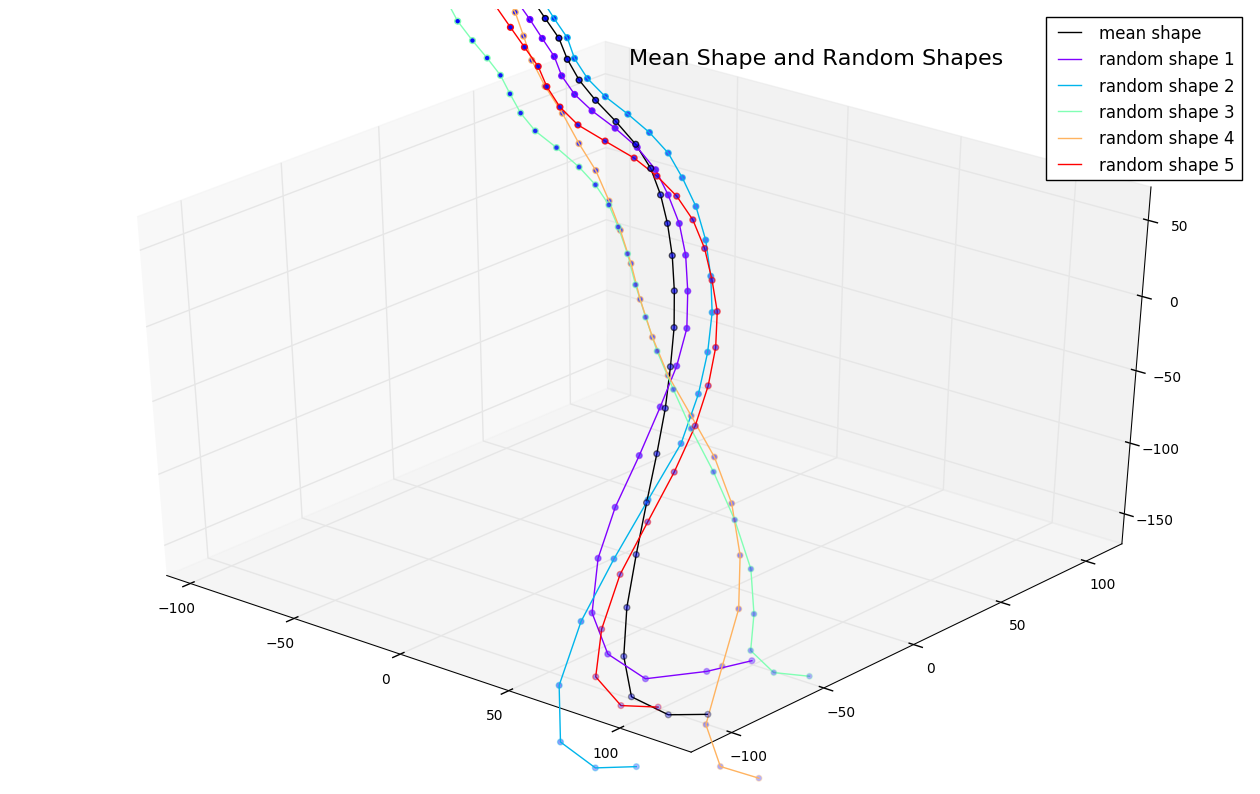

In [7]:
#random sampling of a few shapes from PCA model
scaling = 2;

#Here we show that PCA gives us a generative model
fig = plt.figure(figsize=(16, 10));
std_dev = np.sqrt(D[:num_modes_95+1]);
num_shapes = 5

ax = fig.add_subplot(111, projection='3d');
ax.scatter(aligned_data_mean[x_ind], aligned_data_mean[y_ind], aligned_data_mean[z_ind], s=70, marker='.', color='k')
ax.plot(aligned_data_mean[x_ind], aligned_data_mean[y_ind], aligned_data_mean[z_ind], color='k', label='mean shape')
colors = iter(cm.rainbow(np.linspace(0, 1, num_shapes)))        
for ii in range(num_shapes):
    c_color = next(colors)
    
    
    # sampling random coefficients within scaling * std_dev
    coeffs = np.multiply(np.random.normal(size=[num_modes_95+1]),std_dev*scaling)
    
    
    random_shape = aligned_data_mean - np.dot(U[:,:num_modes_95+1],coeffs);
    ax.scatter(random_shape[x_ind],random_shape[y_ind],random_shape[z_ind], s=70, marker='.', color=c_color);
    ax.plot(random_shape[x_ind], random_shape[y_ind], random_shape[z_ind], color=c_color, label='random shape {0}'.format(ii+1))
ax.set_title('Mean Shape and Random Shapes',fontsize=16,x=0.65);
axisEqual3D(ax)
ax.view_init(35,-50)
plt.legend( loc='upper right' )
plt.show()

## Anomaly detection

The PCA shape model has been constructed from a set of 200 subjects with normal spines. Thus, the modes correspond to normal, non-pathological variations of spinal shape. If we project a new example onto the principal modes we can obtain the coordinates of this examples in the new coordinate system (where the modes correspond to the coordinate axes). The coordinates themselves can tell us something about the 'distance' of an example to the mean shape.

In the following, we will use this to build an anomaly detection system that uses the above PCA model to detect extreme 'outliers' in a set of spine patients.

### Pre-processing

After loading the testing data from the spine patients, we will need to apply a similar pre-processing which aligns the shapes to the same reference as used for the training data. Note, you should always use the pre-processing for both training and testing.

#### TASK IV: Implement a pre-processing step with shape alignment similar to the one for the training data.

num of testing examples: 242


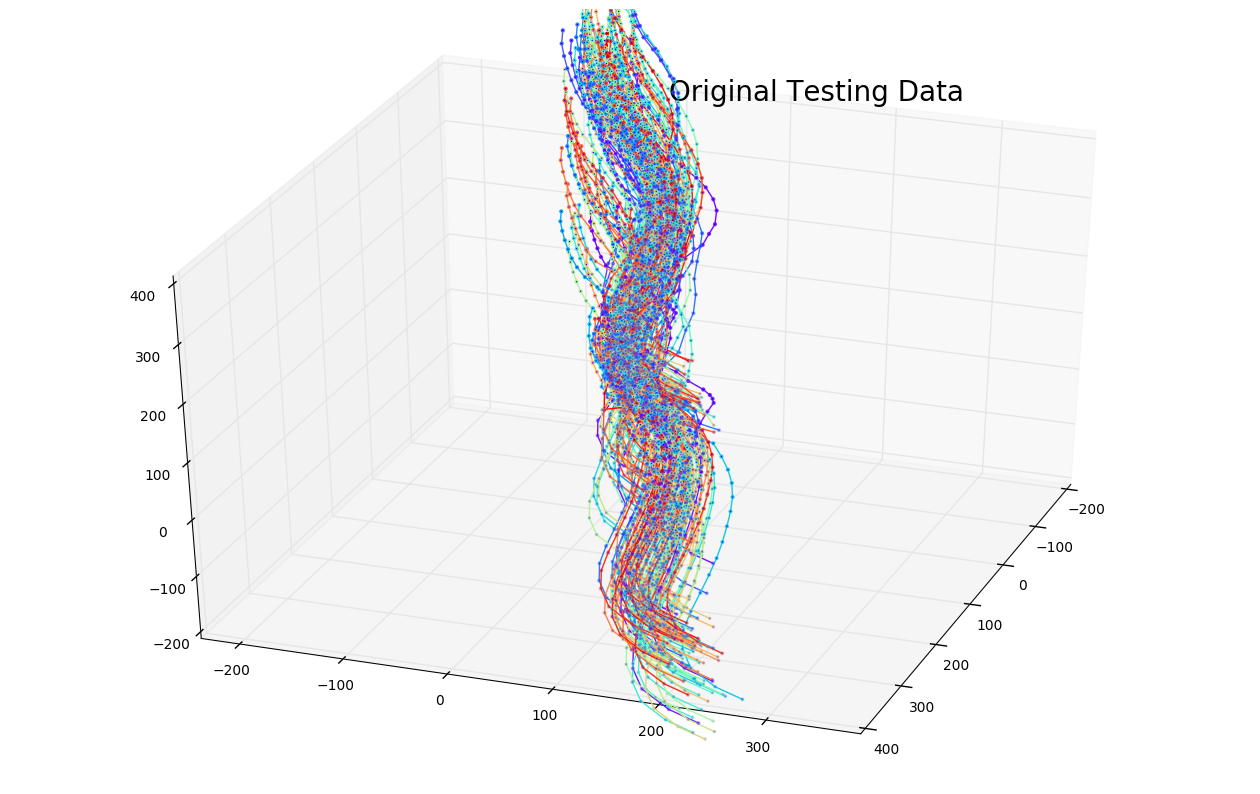

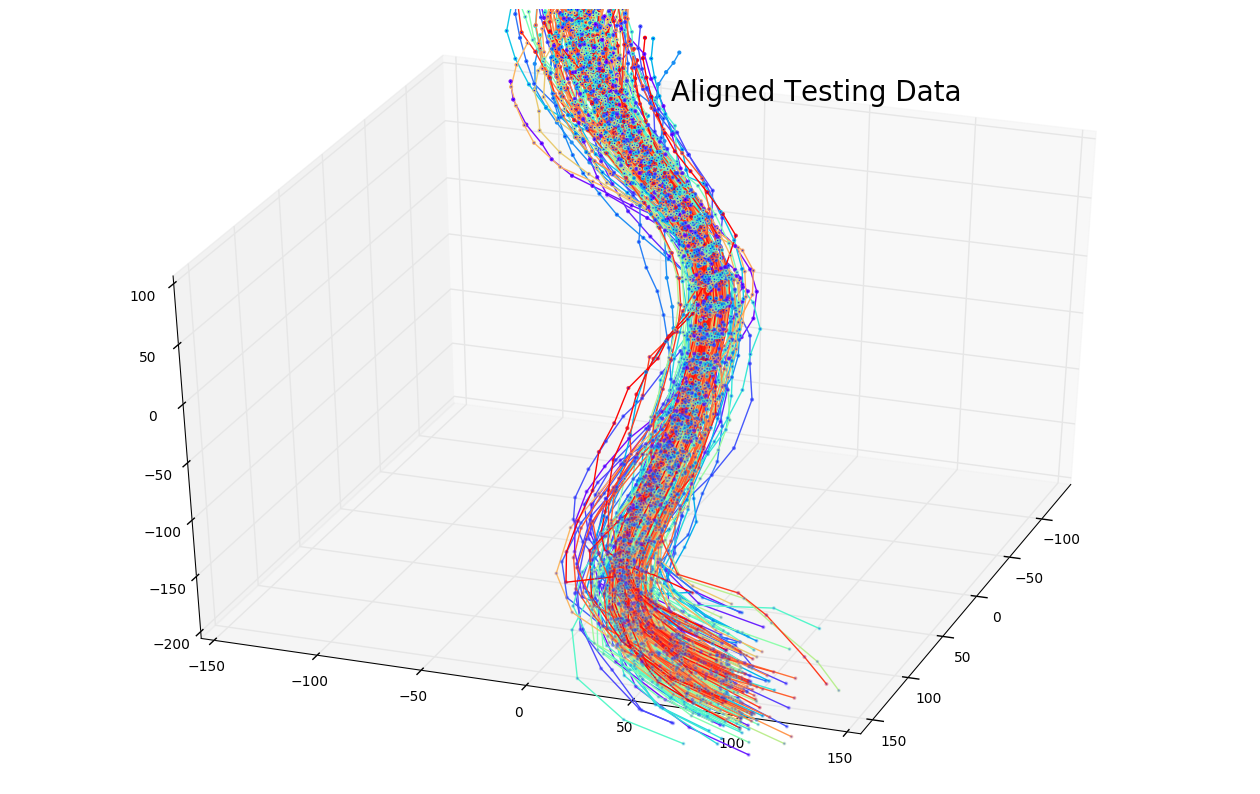

In [8]:
test_data = np.genfromtxt('../data/spine_testing.txt')
num_examples_test = test_data.shape[1]

print 'num of testing examples: %d' % num_examples_test

# align test data in the same way as training data
aligned_testing_data = np.zeros(test_data.shape)

if align == 1:
    cx = test_data[x_ind,:];
    cy = test_data[y_ind,:];
    cz = test_data[z_ind,:];
    aligned_testing_data[x_ind,:] = cx - np.tile(np.mean(cx,axis=0),(num_centroids,1));
    aligned_testing_data[y_ind,:] = cy - np.tile(np.mean(cy,axis=0),(num_centroids,1));
    aligned_testing_data[z_ind,:] = cz - np.tile(np.mean(cz,axis=0),(num_centroids,1));   
    
elif align == 2:
    ref_shape = train_data[:,0].reshape((3, num_centroids))
    for ii in range(0,num_examples_test):
        mov_shape = test_data[:,ii].reshape((3, num_centroids))
        R, t = umeyama_rigid(mov_shape,ref_shape)
        mov_shape = np.dot(R,mov_shape) + np.tile(t, (num_centroids, 1)).transpose()
        aligned_testing_data[:,ii] = mov_shape.reshape((3*num_centroids,1)).flatten()
    
elif align == 3:
    ref_shape = train_data[:,0].reshape((3, num_centroids))
    for ii in range(0,num_examples_test):
        mov_shape = test_data[:,ii].reshape((3, num_centroids))
        R, c, t = umeyama_similarity(mov_shape,ref_shape)
        mov_shape = c * np.dot(R,mov_shape) + np.tile(t, (num_centroids, 1)).transpose()
        aligned_testing_data[:,ii] = mov_shape.reshape((3*num_centroids,1)).flatten()

plotmy3Ddata(test_data,title='Original Testing Data',view=[35,20])

plotmy3Ddata(aligned_testing_data,title='Aligned Testing Data',view=[35,20])

### Projection

A new example X can be projected onto the principal modes via a simple matrix-vector-multiplication U'X, where U' is the transpose of U. However, we need to subtract the mean from X first. The projection gives a vector of coefficients, which are the coordinates of the example in the new coordinate system. Based on the coefficients, we can compute a probability that reflects how likely the example is to be observed given the PCA shape model. The probability is computed by multiplying probabilities individually computed for each mode. The per-mode probabilities p_m can be computed as p_m(c_m) = exp( -0.5 * c_m^2 / (2 * var_m) ) where c_m is the coefficient of mode m and var_m its variance.

In the section below, you will need to fill in the lines for computing the projection and the probabilities. The rest of the code then plots the probabilities sorted by increasing order. You should be able to see a clear difference between the probabilities of the training and the testing examples.

#### TASK V: Implement the projection of the testing data onto the principal modes in order to determine the PCA coefficients. Based on the coefficients, compute probabilities for each example with respect to the modes that retain 95% of the variance. Do this for both the training and the testing examples, so we can then compare their probabilities in the same plot.

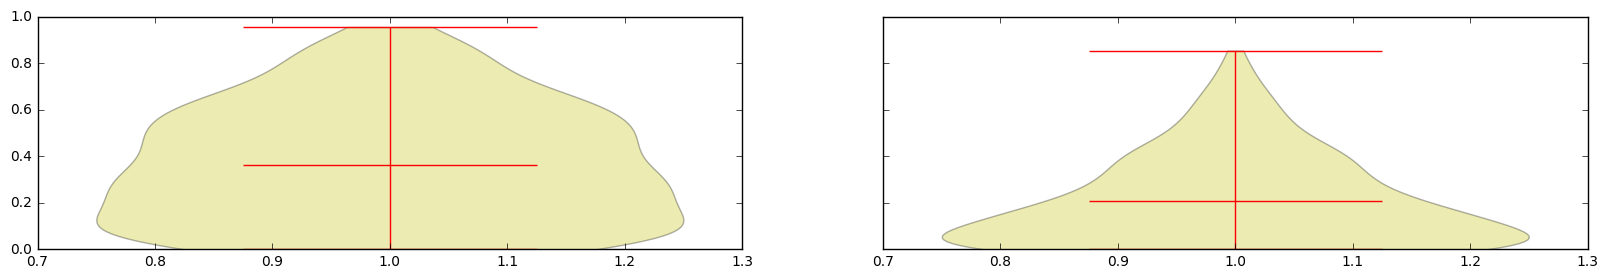

In [9]:
# project test and training data on the PCA shape model
coeffs_test = np.dot(np.transpose(U),(aligned_testing_data - np.transpose(np.tile(aligned_data_mean,(num_examples_test,1)))))
coeffs_train = np.dot(np.transpose(U),(aligned_data - np.transpose(np.tile(aligned_data_mean,(num_examples_train,1)))))

# compute per subject probability, consider only the 95% variance modes
variance = D[:num_modes_95+1];
p_test = np.prod(np.exp(np.divide(- 0.5 * np.power(coeffs_test[:num_modes_95+1,:],2),np.transpose(np.tile(variance*2,(num_examples_test,1))))),axis=0)
p_test,ind_test = np.sort(p_test),np.argsort(p_test)

p_train = np.prod(np.exp(np.divide(- 0.5 * np.power(coeffs_train[:num_modes_95+1,:],2),np.transpose(np.tile(variance*2,(num_examples_train,1))))),axis=0)
p_train,ind_train = np.sort(p_train),np.argsort(p_train)

# plot sorted probabilities
fig = plt.figure(figsize=(12, 8));
ax = fig.add_subplot(111);
ax.plot(p_train,color='b',linestyle='',marker='o',linewidth=1.5,label='training data')
ax.plot(p_test,color='r',linestyle='',marker='o',linewidth=1.5,label='testing data')
ax.grid(True)
ax.tick_params(axis='both', which='major', labelsize=15)
ax.set_title('Sorted shape probabilities',fontsize=16)
ax.set_xlabel('Sample Points',fontsize=16)
ax.set_ylabel('Similarity between the mean shape and sample shape',fontsize=16)
plt.legend( loc='upper left',prop={'size':16} )
plt.show()

fig, axs = plt.subplots(1, 2, sharey=True, figsize=(20,3))
axs[0].violinplot(p_train, showmeans=True)
axs[1].violinplot(p_test, showmeans=True)
plt.show()

### Outlier detection

The last section is for illustration purposes only. The five most extreme shapes from the testing dataset, which are the ones with the lowest probabilities, are plotted and compared to the mean shape. You can play around with the number of shapes to plot more or less shapes, and you can even plot the most extreme shapes from the training data to see the difference between normal and abnormal shapes.

In [10]:
# plot the 5 most abnormal ones from the patient dataset
num_shapes = 5

fig = plt.figure(figsize=(16, 10));

ax = fig.add_subplot(111, projection='3d');
ax.scatter(aligned_data_mean[x_ind], aligned_data_mean[y_ind], aligned_data_mean[z_ind], s=70, marker='.', color='k')
ax.plot(aligned_data_mean[x_ind], aligned_data_mean[y_ind], aligned_data_mean[z_ind], color='k', label='mean shape')
colors = iter(cm.rainbow(np.linspace(0, 1, num_shapes)))        
for ii in range(num_shapes):
    c_color = next(colors)
    
    #testing data
    abnormal_shape = aligned_testing_data[:,ind_test[ii]]
    
    #training data
    #abnormal_shape = aligned_data[:,ind_train[ii]]
    
    ax.scatter(abnormal_shape[x_ind],abnormal_shape[y_ind],abnormal_shape[z_ind], s=70, marker='.', color=c_color);
    ax.plot(abnormal_shape[x_ind], abnormal_shape[y_ind], abnormal_shape[z_ind], color=c_color, label='abnormal shape {0}'.format(ii))
ax.set_title('Mean Shape and Abnormal Shapes',fontsize=16,x=0.65);
axisEqual3D(ax)
ax.view_init(35,-50)
plt.legend( loc='upper right' )
plt.show()